In [1]:
#saving a link to https://github.com/facebook/prophet/tree/master/notebooks
import pandas as pd
import altair as alt
from fbprophet import Prophet

In [2]:
#read in data as csv... change later
dataframe = pd.read_csv('C:\\Users\\Ben\\Desktop\\internship\\csvtest.csv')

#renaming the columns to ds and y; ds is the column with dates and y is the column with values
#timestamp format is ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp
dataframe = dataframe.rename(columns={'Month':'ds', 'Sales':'y'})

#preview part of the data
dataframe.head()

,ds,y
0,6/9/2018 2:01:00 PM,266.0
1,6/10/2018 2:01:00 PM,145.9
2,6/11/2018 2:01:00 PM,183.1
3,6/12/2018 2:01:00 PM,119.3
4,6/13/2018 2:01:00 PM,180.3


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


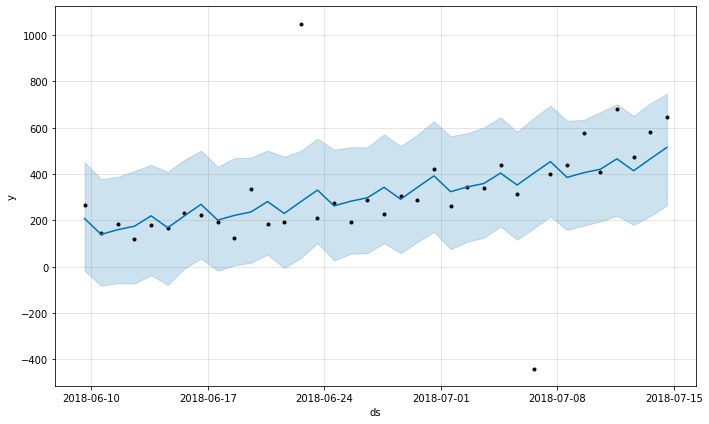

In [8]:
#creating the model & fitting it to the data
interval_width = 0.75 #determines the size of the uncertainty interval - smaller values will generally cause more points to be marked as outliers
model = Prophet(interval_width = interval_width)
model.fit(dataframe) #this line is expectedly slower depending on # of datapoints...

#having the model generate expected values for all current timestamps/dates in the dataframe
forecast = model.predict(dataframe)
forecast['fact'] = dataframe['y'].reset_index(drop = True)
#plotting
fig1 = model.plot(forecast)

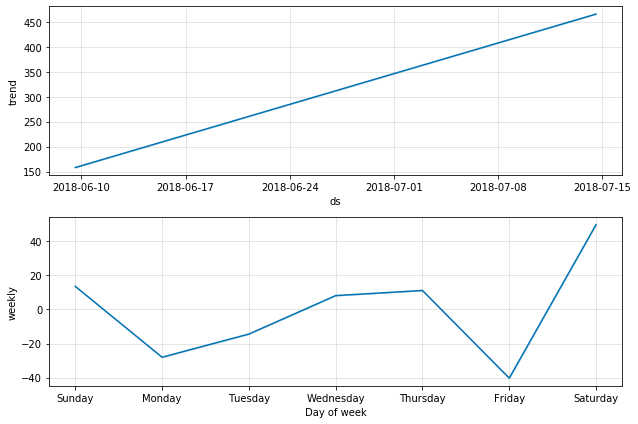

In [9]:
fig2 = model.plot_components(forecast)

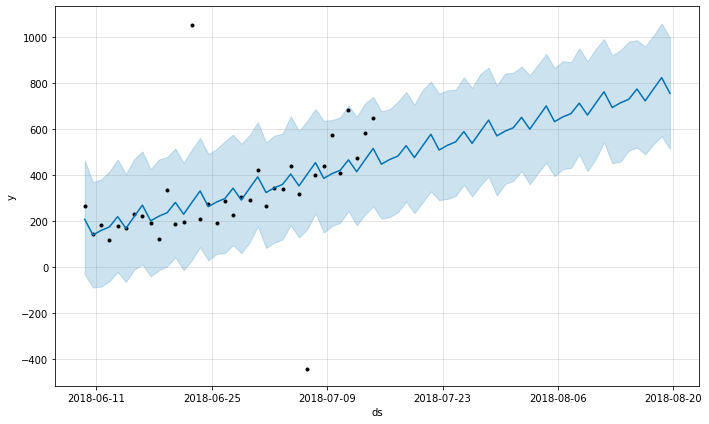

In [5]:
#predicting future values
future_dataframe = model.make_future_dataframe(periods=len(dataframe.index))
future_dataframe.tail()

future_forecast = model.predict(future_dataframe)
fig3= model.plot(future_forecast)

In [6]:
#anomaly detection
forecast['anomaly'] = 0
#marking anomalies where the true value (fact) is larger or lower than model's uncertainty interval
forecast.loc[forecast['fact'] > forecast['yhat_upper'], 'anomaly'] = 1
forecast.loc[forecast['fact'] < forecast['yhat_lower'], 'anomaly'] = -1

#anomaly importances
forecast['importance'] = 0
#attempting to calculate the "severity" of each anomaly by how far from the uncertainty interval it actually is
forecast.loc[forecast['anomaly'] ==1, 'importance'] = \
    (forecast['fact'] - forecast['yhat_upper'])/forecast['fact']
forecast.loc[forecast['anomaly'] ==-1, 'importance'] = \
    (forecast['yhat_lower'] - forecast['fact'])/forecast['fact']

#graph anomalies
alt.data_transformers.enable('default', max_rows=None)
interval = alt.Chart(forecast).mark_area(interpolate="basis", color = '#7FC97F').encode(
x=alt.X('ds:T',  title ='date'),
y='yhat_upper',
y2='yhat_lower',
tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper']
).interactive().properties(
    title='Anomaly Detection'
)

#generating the black dots showing datapoints
fact = alt.Chart(forecast[forecast.anomaly==0]).mark_circle(size=15, opacity=0.7, color = 'Black').encode(
    x='ds:T',
    y=alt.Y('fact', title='sales'),    
    tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper']
).interactive()

#generating the red marks showing anomaly locations
anomalies = alt.Chart(forecast[forecast.anomaly!=0]).mark_circle(size=30, color = 'Red').encode(
    x='ds:T',
    y=alt.Y('fact', title='sales'),    
    tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper'],
).interactive()

#display the 3 layered
alt.layer(interval, fact, anomalies)\
              .properties(width=870, height=450)\
              .configure_title(fontSize=20)

#plot doesn't seem to render on github; included as altair_plot.jpg in repo

alt.LayerChart(...)

In [7]:
#Finding the timestamps of marked anomalies
print("Times of anomalies: ")
for i in range(0, len(forecast['ds'])):
    if(forecast['anomaly'][i] != 0):
        print("Datapoint #" + str(i) + ":   " + str(forecast['ds'][i]) + "      Importance: " + str(abs(forecast['importance'][i])))

Times of anomalies: 
Datapoint #13:   2018-06-22 14:01:00      Importance: 0.5003052985797156
Datapoint #27:   2018-07-06 14:01:00      Importance: 1.365724243323077
